In [1]:
!mkdir -p /scratch/sagarsj42/torch-cache
!mkdir -p /scratch/sagarsj42/transformers

import os
os.chdir('/scratch/sagarsj42')
os.environ['TORCH_HOME'] = '/scratch/sagarsj42/torch-cache'
os.environ['TRANSFORMERS_CACHE'] = '/scratch/sagarsj42/transformers'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [9]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel
from transformers import DataCollatorWithPadding
from transformers import Trainer, TrainingArguments

In [3]:
TRAIN_DATA_FILE = 'irse.train.csv'
DEV_DATA_FILE = 'irse.dev.csv'
TEST_DATA_FILE = 'irse.test.csv'
GIVEN_TEST_FILE = 'irse.given-test.csv'
MODEL_KEY = 'roberta-base'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE

device(type='cuda')

In [4]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_KEY)
model = AutoModel.from_pretrained(MODEL_KEY).to(DEVICE)

tokenizer, model

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(PreTrainedTokenizerFast(name_or_path='roberta-base', vocab_size=50265, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=False)}),
 RobertaModel(
   (embeddings): RobertaEmbeddings(
     (word_embeddings): Embedding(50265, 768, padding_idx=1)
     (position_embeddings): Embedding(514, 768, padding_idx=1)
     (token_type_embeddings): Embedding(1, 768)
     (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
     (dropout): Dropout(p=0.1, inplace=False)
   )
   (encoder): RobertaEncoder(
     (layer): ModuleList(
       (0): RobertaLayer(
         (attention): RobertaAttention(
           (self): RobertaSelfAttention(
             (query): Linear(in_features=768, out_features=768, bias=True)
             (key): 

In [5]:
data_files = {
    'train': TRAIN_DATA_FILE,
    'dev': DEV_DATA_FILE,
    'test': TEST_DATA_FILE,
    'giventest': GIVEN_TEST_FILE
}
ds = load_dataset('csv', data_files=data_files)

ds

Using custom data configuration default-5dfb8978262fb122
Found cached dataset csv (/home2/sagarsj42/.cache/huggingface/datasets/csv/default-5dfb8978262fb122/0.0.0/652c3096f041ee27b04d2232d41f10547a8fecda3e284a79a0ec4053c916ef7a)
100%|██████████| 4/4 [00:00<00:00, 353.41it/s]


DatasetDict({
    train: Dataset({
        features: ['Comments', 'Surrounding Code Context', 'Class', 'label'],
        num_rows: 5354
    })
    dev: Dataset({
        features: ['Comments', 'Surrounding Code Context', 'Class', 'label'],
        num_rows: 595
    })
    test: Dataset({
        features: ['Comments', 'Surrounding Code Context', 'Class', 'label'],
        num_rows: 678
    })
    giventest: Dataset({
        features: ['Comments', 'Surrounding Code Context', 'Class', 'label'],
        num_rows: 1001
    })
})

In [7]:
scores = np.zeros(len(ds['dev']))
labels = np.zeros(len(ds['dev']))

for i in range(len(ds['dev'])):
    comment = ds['dev'][i]['Comments']
    code = ds['dev'][i]['Surrounding Code Context']
    tok = tokenizer([comment, code], return_tensors='pt', truncation=True, padding=True).to(DEVICE)
    enc = model(**tok).last_hidden_state.sum(dim=1).detach().cpu().numpy()
    comment_e, code_e = enc
    cos_score = np.dot(comment_e, code_e) / (np.linalg.norm(comment_e) * np.linalg.norm(code_e))
    scores[i] = cos_score
    labels[i] = ds['dev'][i]['label']

In [8]:
scores.mean(), scores.std(), np.median(scores), scores.min(), scores.max()

(0.8450869612333154,
 0.07020000647588685,
 0.851645827293396,
 0.594062864780426,
 0.9934926629066467)

In [11]:
score_label_df = pd.DataFrame({'scores': scores, 'labels': labels})

score_label_df.describe()

,scores,labels
count,595.000000,595.000000
mean,0.845087,0.568067
std,0.070259,0.495762
min,0.594063,0.000000
25%,0.802148,0.000000
50%,0.851646,1.000000
75%,0.895816,1.000000
max,0.993493,1.000000


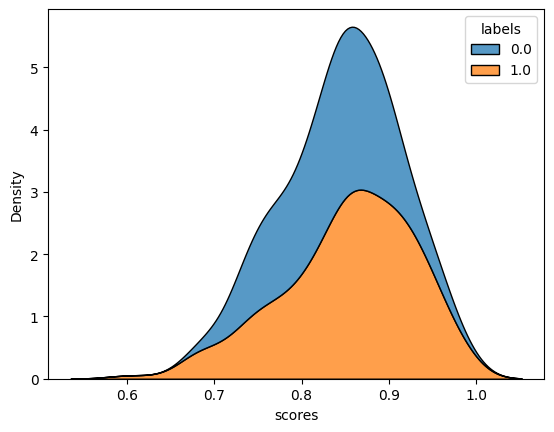

In [19]:
sns.kdeplot(score_label_df, x='scores', hue='labels', multiple='stack')
plt.show()